# Audio Style transfer 
This is a note book largely showcasing the work of Dmitry Ulyanov
[link to original github](https://github.com/DmitryUlyanov/neural-style-audio-tf)


Loosley base on the work using Style Transfer on images  [link to neural-style-tf](https://github.com/cysmith/neural-style-tf)



## Install librosa

run 
`!conda install -c conda-forge librosa -y`

In [2]:
import librosa

In [3]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

### Load style and content

In [43]:
CONTENT_FILENAME = "inputs/usa.mp3"
STYLE_FILENAME = "inputs/russia.mp3"
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

>The default value, ``n_fft=2048`` samples, corresponds to a physical
    duration of 93 milliseconds at a sample rate of 22050 Hz

In [44]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    #time series & sampling rate
    x, fs = librosa.load(filename)
    #time series , 
    #Short-time Fourier transform 
    S = librosa.stft(x, N_FFT)
     #returns    Complex-valued matrix of short-term Fourier transform coefficients.
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [45]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


### Visualize spectrograms for content and style tracks

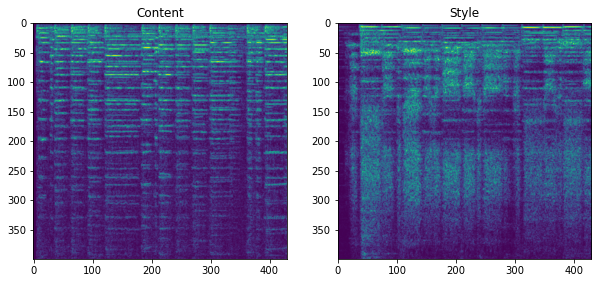

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [47]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1], #image number  x ,y     #input channel
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [48]:
from sys import stderr

ALPHA= 1e-3
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print ('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 99.677437
  Number of iterations: 300
  Number of functions evaluations: 319
Final loss: 99.67744


### Invert spectrogram and save the result

In [38]:
import soundfile as sf
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/usa_russia.wav'
# Write out audio as 24bit PCM WAV
sf.write(OUTPUT_FILENAME, x, fs, subtype='PCM_24')



In [39]:
print (OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/russia_valk.wav


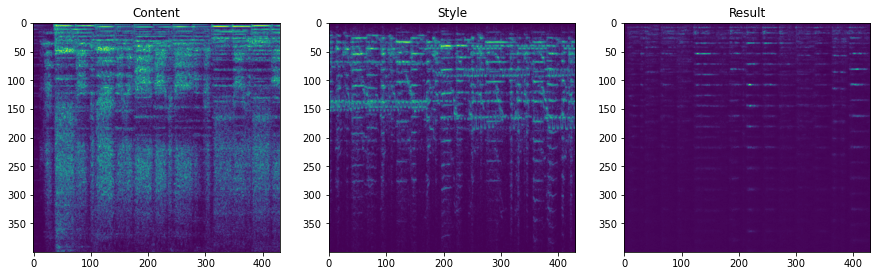

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

### Visualize spectrograms

In [26]:
print (OUTPUT_FILENAME)
CONTENT_FILENAME = "inputs/usa.mp3"
STYLE_FILENAME = "inputs/imperial.mp3"
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))
display(Audio('outputs/imperial_USA.wav'))

outputs/imperial_USA.wav


In [41]:
CONTENT_FILENAME = "inputs/russia.mp3"
STYLE_FILENAME = "inputs/valkyries.mp3"
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))
display(Audio('outputs/russia_valk.wav'))